In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# download the dataset to your folder or use it on kaggle notebook directly

train_file = np.load('../../../train.npz')
# train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')
train_data = train_file['data']

test_file = np.load('../../../test_input.npz')
# test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')
test_data = test_file['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :5]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
import sys
sys.path.append('../..')
from TrajectoryDataset import TrajectoryDatasetTrain, TrajectoryDatasetTest
from utils import train_model

sys.path.append('../../..')
from models.deep_cnn import DeepCNNModel

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.data import Batch

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 5.0

N = len(train_data)
val_size = int(0.05 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=False, center_agent=0, scene=0)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False, center_agent=0, scene=0)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [8]:
# Create the model
deep_cnn_model = DeepCNNModel(train_data.shape[3])

# Define loss function and optimizer
deep_cnn_criterion = nn.MSELoss()  # For regression task

deep_cnn_optimizer = optim.AdamW(deep_cnn_model.parameters(), lr=0.0005, weight_decay=1e-4)

deep_cnn_scheduler = CosineAnnealingLR(deep_cnn_optimizer, T_max=200, eta_min=1e-6)

In [9]:
deep_cnn_model = deep_cnn_model.to(device)
train_model(
    deep_cnn_model, 
    train_dataloader, 
    val_dataloader, 
    device, 
    deep_cnn_optimizer, 
    deep_cnn_criterion, 
    deep_cnn_scheduler, 
    50,
    "deep_cnn_weights",
    400
)

Epoch:   0%|          | 1/400 [00:09<1:03:06,  9.49s/epoch]

Epoch 000 | Learning rate 0.000500 | train normalized MSE  63.4158 | val normalized MSE  64.2182, | val unnormalized MAE  25.9139 | val unnormalized MSE 1605.4563


Epoch:   0%|          | 2/400 [00:12<36:35,  5.52s/epoch]  

Epoch 001 | Learning rate 0.000500 | train normalized MSE  62.4546 | val normalized MSE  64.1954, | val unnormalized MAE  25.9076 | val unnormalized MSE 1604.8862


Epoch:   1%|          | 3/400 [00:14<27:42,  4.19s/epoch]

Epoch 002 | Learning rate 0.000500 | train normalized MSE  62.0588 | val normalized MSE  64.1785, | val unnormalized MAE  25.9752 | val unnormalized MSE 1604.4620


Epoch:   1%|          | 4/400 [00:17<23:38,  3.58s/epoch]

Epoch 003 | Learning rate 0.000500 | train normalized MSE  61.2954 | val normalized MSE  57.4250, | val unnormalized MAE  25.4945 | val unnormalized MSE 1435.6246


Epoch:   1%|▏         | 5/400 [00:20<21:36,  3.28s/epoch]

Epoch 004 | Learning rate 0.000499 | train normalized MSE  27.4341 | val normalized MSE  38.3577, | val unnormalized MAE  28.4365 | val unnormalized MSE 958.9430


Epoch:   2%|▏         | 6/400 [00:22<20:18,  3.09s/epoch]

Epoch 005 | Learning rate 0.000499 | train normalized MSE   3.4469 | val normalized MSE  69.4927, | val unnormalized MAE  40.0229 | val unnormalized MSE 1737.3168


Epoch:   2%|▏         | 7/400 [00:25<19:37,  3.00s/epoch]

Epoch 006 | Learning rate 0.000498 | train normalized MSE   2.5242 | val normalized MSE  87.3802, | val unnormalized MAE  44.9030 | val unnormalized MSE 2184.5045


Epoch:   2%|▏         | 8/400 [00:28<18:59,  2.91s/epoch]

Epoch 007 | Learning rate 0.000498 | train normalized MSE   2.4591 | val normalized MSE  13.5346, | val unnormalized MAE  16.8989 | val unnormalized MSE 338.3658


Epoch:   2%|▏         | 9/400 [00:31<20:06,  3.09s/epoch]

Epoch 008 | Learning rate 0.000498 | train normalized MSE   1.8578 | val normalized MSE   6.2009, | val unnormalized MAE  10.0091 | val unnormalized MSE 155.0233


Epoch:   2%|▎         | 10/400 [00:35<20:42,  3.18s/epoch]

Epoch 009 | Learning rate 0.000497 | train normalized MSE   1.6692 | val normalized MSE  13.6069, | val unnormalized MAE  16.7103 | val unnormalized MSE 340.1720


Epoch:   3%|▎         | 11/400 [00:39<21:57,  3.39s/epoch]

Epoch 010 | Learning rate 0.000496 | train normalized MSE   1.5260 | val normalized MSE  17.1108, | val unnormalized MAE  19.0889 | val unnormalized MSE 427.7695


Epoch:   3%|▎         | 12/400 [00:42<22:17,  3.45s/epoch]

Epoch 011 | Learning rate 0.000496 | train normalized MSE   1.6677 | val normalized MSE   7.2351, | val unnormalized MAE  11.9871 | val unnormalized MSE 180.8778


Epoch:   3%|▎         | 13/400 [00:46<22:53,  3.55s/epoch]

Epoch 012 | Learning rate 0.000495 | train normalized MSE   1.3111 | val normalized MSE  30.8590, | val unnormalized MAE  26.4631 | val unnormalized MSE 771.4756


Epoch:   4%|▎         | 14/400 [00:50<23:57,  3.73s/epoch]

Epoch 013 | Learning rate 0.000494 | train normalized MSE   1.5038 | val normalized MSE   4.4235, | val unnormalized MAE   8.7337 | val unnormalized MSE 110.5872


Epoch:   4%|▍         | 15/400 [00:54<23:20,  3.64s/epoch]

Epoch 014 | Learning rate 0.000493 | train normalized MSE   1.5060 | val normalized MSE   3.7492, | val unnormalized MAE   6.9244 | val unnormalized MSE  93.7296


Epoch:   4%|▍         | 16/400 [00:57<22:53,  3.58s/epoch]

Epoch 015 | Learning rate 0.000492 | train normalized MSE   1.7577 | val normalized MSE 117.8690, | val unnormalized MAE  52.0084 | val unnormalized MSE 2946.7252


Epoch:   4%|▍         | 17/400 [01:01<22:37,  3.55s/epoch]

Epoch 016 | Learning rate 0.000491 | train normalized MSE   1.4707 | val normalized MSE   1.9823, | val unnormalized MAE   5.1024 | val unnormalized MSE  49.5567


Epoch:   4%|▍         | 18/400 [01:04<22:22,  3.51s/epoch]

Epoch 017 | Learning rate 0.000490 | train normalized MSE   1.3522 | val normalized MSE  10.6364, | val unnormalized MAE  14.7239 | val unnormalized MSE 265.9110


Epoch:   5%|▍         | 19/400 [01:07<22:17,  3.51s/epoch]

Epoch 018 | Learning rate 0.000489 | train normalized MSE   1.3475 | val normalized MSE   5.0534, | val unnormalized MAE   9.8288 | val unnormalized MSE 126.3361


Epoch:   5%|▌         | 20/400 [01:11<22:02,  3.48s/epoch]

Epoch 019 | Learning rate 0.000488 | train normalized MSE   1.3575 | val normalized MSE   1.6242, | val unnormalized MAE   4.5985 | val unnormalized MSE  40.6040


Epoch:   5%|▌         | 21/400 [01:14<21:51,  3.46s/epoch]

Epoch 020 | Learning rate 0.000487 | train normalized MSE   1.3068 | val normalized MSE  28.1744, | val unnormalized MAE  25.2926 | val unnormalized MSE 704.3595


Epoch:   6%|▌         | 22/400 [01:18<21:47,  3.46s/epoch]

Epoch 021 | Learning rate 0.000485 | train normalized MSE   1.1154 | val normalized MSE  16.3808, | val unnormalized MAE  19.1254 | val unnormalized MSE 409.5190


Epoch:   6%|▌         | 23/400 [01:21<21:35,  3.44s/epoch]

Epoch 022 | Learning rate 0.000484 | train normalized MSE   1.1505 | val normalized MSE  16.2374, | val unnormalized MAE  18.7077 | val unnormalized MSE 405.9350


Epoch:   6%|▌         | 24/400 [01:24<21:17,  3.40s/epoch]

Epoch 023 | Learning rate 0.000482 | train normalized MSE   1.3200 | val normalized MSE   4.3550, | val unnormalized MAE   8.8650 | val unnormalized MSE 108.8739


Epoch:   6%|▋         | 25/400 [01:28<21:00,  3.36s/epoch]

Epoch 024 | Learning rate 0.000481 | train normalized MSE   1.1781 | val normalized MSE   1.6892, | val unnormalized MAE   4.4618 | val unnormalized MSE  42.2306


Epoch:   6%|▋         | 26/400 [01:31<20:51,  3.35s/epoch]

Epoch 025 | Learning rate 0.000479 | train normalized MSE   1.0754 | val normalized MSE  20.5940, | val unnormalized MAE  21.3121 | val unnormalized MSE 514.8510


Epoch:   7%|▋         | 27/400 [01:34<20:46,  3.34s/epoch]

Epoch 026 | Learning rate 0.000478 | train normalized MSE   1.0712 | val normalized MSE   1.2792, | val unnormalized MAE   3.9408 | val unnormalized MSE  31.9792


Epoch:   7%|▋         | 28/400 [01:38<20:47,  3.35s/epoch]

Epoch 027 | Learning rate 0.000476 | train normalized MSE   1.0053 | val normalized MSE   7.3796, | val unnormalized MAE  11.8256 | val unnormalized MSE 184.4894


Epoch:   7%|▋         | 29/400 [01:41<20:36,  3.33s/epoch]

Epoch 028 | Learning rate 0.000475 | train normalized MSE   1.1439 | val normalized MSE   2.3309, | val unnormalized MAE   5.6823 | val unnormalized MSE  58.2720


Epoch:   8%|▊         | 30/400 [01:44<20:32,  3.33s/epoch]

Epoch 029 | Learning rate 0.000473 | train normalized MSE   1.0066 | val normalized MSE   3.4257, | val unnormalized MAE   7.5388 | val unnormalized MSE  85.6438


Epoch:   8%|▊         | 31/400 [01:48<20:30,  3.34s/epoch]

Epoch 030 | Learning rate 0.000471 | train normalized MSE   1.0613 | val normalized MSE   2.4068, | val unnormalized MAE   5.8205 | val unnormalized MSE  60.1702


Epoch:   8%|▊         | 32/400 [01:51<20:31,  3.35s/epoch]

Epoch 031 | Learning rate 0.000469 | train normalized MSE   0.9742 | val normalized MSE   4.9469, | val unnormalized MAE   9.3005 | val unnormalized MSE 123.6731


Epoch:   8%|▊         | 33/400 [01:54<20:28,  3.35s/epoch]

Epoch 032 | Learning rate 0.000467 | train normalized MSE   1.0827 | val normalized MSE   4.5809, | val unnormalized MAE   8.9763 | val unnormalized MSE 114.5229


Epoch:   8%|▊         | 34/400 [01:58<20:31,  3.36s/epoch]

Epoch 033 | Learning rate 0.000465 | train normalized MSE   1.0387 | val normalized MSE   3.3230, | val unnormalized MAE   7.0232 | val unnormalized MSE  83.0749


Epoch:   9%|▉         | 35/400 [02:01<20:30,  3.37s/epoch]

Epoch 034 | Learning rate 0.000463 | train normalized MSE   0.9353 | val normalized MSE   6.5895, | val unnormalized MAE  10.6694 | val unnormalized MSE 164.7375


Epoch:   9%|▉         | 36/400 [02:05<20:28,  3.38s/epoch]

Epoch 035 | Learning rate 0.000461 | train normalized MSE   0.9790 | val normalized MSE   2.8795, | val unnormalized MAE   6.0646 | val unnormalized MSE  71.9872


Epoch:   9%|▉         | 37/400 [02:08<20:30,  3.39s/epoch]

Epoch 036 | Learning rate 0.000459 | train normalized MSE   0.8733 | val normalized MSE  19.5800, | val unnormalized MAE  20.8280 | val unnormalized MSE 489.4991


Epoch:  10%|▉         | 38/400 [02:11<20:29,  3.40s/epoch]

Epoch 037 | Learning rate 0.000457 | train normalized MSE   0.9697 | val normalized MSE   1.3509, | val unnormalized MAE   3.9492 | val unnormalized MSE  33.7725


Epoch:  10%|▉         | 39/400 [02:15<20:26,  3.40s/epoch]

Epoch 038 | Learning rate 0.000455 | train normalized MSE   0.9806 | val normalized MSE   2.2644, | val unnormalized MAE   5.3475 | val unnormalized MSE  56.6089


Epoch:  10%|█         | 40/400 [02:18<20:28,  3.41s/epoch]

Epoch 039 | Learning rate 0.000452 | train normalized MSE   1.1120 | val normalized MSE   3.1131, | val unnormalized MAE   6.9659 | val unnormalized MSE  77.8283


Epoch:  10%|█         | 41/400 [02:22<20:18,  3.39s/epoch]

Epoch 040 | Learning rate 0.000450 | train normalized MSE   1.3054 | val normalized MSE   7.7325, | val unnormalized MAE  11.4439 | val unnormalized MSE 193.3122


Epoch:  10%|█         | 42/400 [02:25<20:07,  3.37s/epoch]

Epoch 041 | Learning rate 0.000448 | train normalized MSE   0.9097 | val normalized MSE   1.9095, | val unnormalized MAE   4.4943 | val unnormalized MSE  47.7372


Epoch:  11%|█         | 43/400 [02:28<20:12,  3.40s/epoch]

Epoch 042 | Learning rate 0.000445 | train normalized MSE   1.0832 | val normalized MSE   3.3444, | val unnormalized MAE   7.0502 | val unnormalized MSE  83.6099


Epoch:  11%|█         | 44/400 [02:32<20:12,  3.41s/epoch]

Epoch 043 | Learning rate 0.000443 | train normalized MSE   0.9884 | val normalized MSE   1.9756, | val unnormalized MAE   4.9997 | val unnormalized MSE  49.3894


Epoch:  11%|█▏        | 45/400 [02:35<20:09,  3.41s/epoch]

Epoch 044 | Learning rate 0.000440 | train normalized MSE   1.4291 | val normalized MSE   4.4763, | val unnormalized MAE   7.6346 | val unnormalized MSE 111.9079


Epoch:  12%|█▏        | 46/400 [02:39<20:17,  3.44s/epoch]

Epoch 045 | Learning rate 0.000438 | train normalized MSE   1.1202 | val normalized MSE   2.2567, | val unnormalized MAE   5.2023 | val unnormalized MSE  56.4178


Epoch:  12%|█▏        | 47/400 [02:42<20:20,  3.46s/epoch]

Epoch 046 | Learning rate 0.000435 | train normalized MSE   1.1339 | val normalized MSE   3.8405, | val unnormalized MAE   7.7651 | val unnormalized MSE  96.0120


Epoch:  12%|█▏        | 48/400 [02:46<20:15,  3.45s/epoch]

Epoch 047 | Learning rate 0.000432 | train normalized MSE   1.0530 | val normalized MSE  11.1175, | val unnormalized MAE  15.3186 | val unnormalized MSE 277.9372


Epoch:  12%|█▏        | 49/400 [02:49<20:16,  3.47s/epoch]

Epoch 048 | Learning rate 0.000430 | train normalized MSE   0.9528 | val normalized MSE   2.2741, | val unnormalized MAE   5.5571 | val unnormalized MSE  56.8514


Epoch:  12%|█▎        | 50/400 [02:53<20:12,  3.47s/epoch]

Epoch 049 | Learning rate 0.000427 | train normalized MSE   1.0363 | val normalized MSE   8.2903, | val unnormalized MAE  12.4978 | val unnormalized MSE 207.2566


Epoch:  13%|█▎        | 51/400 [02:56<20:11,  3.47s/epoch]

Epoch 050 | Learning rate 0.000424 | train normalized MSE   0.8948 | val normalized MSE   3.1887, | val unnormalized MAE   7.0266 | val unnormalized MSE  79.7170


Epoch:  13%|█▎        | 52/400 [03:00<20:08,  3.47s/epoch]

Epoch 051 | Learning rate 0.000421 | train normalized MSE   0.8634 | val normalized MSE   0.9139, | val unnormalized MAE   3.0829 | val unnormalized MSE  22.8487


Epoch:  13%|█▎        | 53/400 [03:03<20:05,  3.47s/epoch]

Epoch 052 | Learning rate 0.000418 | train normalized MSE   0.9129 | val normalized MSE   1.1999, | val unnormalized MAE   3.7572 | val unnormalized MSE  29.9974


Epoch:  14%|█▎        | 54/400 [03:07<19:59,  3.47s/epoch]

Epoch 053 | Learning rate 0.000415 | train normalized MSE   0.9192 | val normalized MSE   4.6124, | val unnormalized MAE   7.7106 | val unnormalized MSE 115.3106


Epoch:  14%|█▍        | 55/400 [03:10<19:51,  3.45s/epoch]

Epoch 054 | Learning rate 0.000413 | train normalized MSE   1.0203 | val normalized MSE   2.8984, | val unnormalized MAE   5.8821 | val unnormalized MSE  72.4605


Epoch:  14%|█▍        | 56/400 [03:13<19:40,  3.43s/epoch]

Epoch 055 | Learning rate 0.000410 | train normalized MSE   1.0675 | val normalized MSE   6.3377, | val unnormalized MAE  10.2680 | val unnormalized MSE 158.4416


Epoch:  14%|█▍        | 57/400 [03:17<19:35,  3.43s/epoch]

Epoch 056 | Learning rate 0.000406 | train normalized MSE   0.8219 | val normalized MSE   5.3962, | val unnormalized MAE   9.7724 | val unnormalized MSE 134.9046


Epoch:  14%|█▍        | 58/400 [03:20<19:31,  3.42s/epoch]

Epoch 057 | Learning rate 0.000403 | train normalized MSE   0.8886 | val normalized MSE   1.9598, | val unnormalized MAE   5.0256 | val unnormalized MSE  48.9940


Epoch:  15%|█▍        | 59/400 [03:24<19:23,  3.41s/epoch]

Epoch 058 | Learning rate 0.000400 | train normalized MSE   0.7931 | val normalized MSE   1.0396, | val unnormalized MAE   3.6064 | val unnormalized MSE  25.9893


Epoch:  15%|█▌        | 60/400 [03:27<19:15,  3.40s/epoch]

Epoch 059 | Learning rate 0.000397 | train normalized MSE   0.8929 | val normalized MSE   0.8776, | val unnormalized MAE   3.2155 | val unnormalized MSE  21.9404


Epoch:  15%|█▌        | 61/400 [03:30<18:56,  3.35s/epoch]

Epoch 060 | Learning rate 0.000394 | train normalized MSE   0.9171 | val normalized MSE   1.6139, | val unnormalized MAE   4.4078 | val unnormalized MSE  40.3471


Epoch:  16%|█▌        | 62/400 [03:33<18:46,  3.33s/epoch]

Epoch 061 | Learning rate 0.000391 | train normalized MSE   0.8238 | val normalized MSE   1.7961, | val unnormalized MAE   4.6658 | val unnormalized MSE  44.9020


Epoch:  16%|█▌        | 63/400 [03:37<18:41,  3.33s/epoch]

Epoch 062 | Learning rate 0.000387 | train normalized MSE   0.7848 | val normalized MSE   0.6269, | val unnormalized MAE   2.5668 | val unnormalized MSE  15.6732


Epoch:  16%|█▌        | 64/400 [03:40<18:38,  3.33s/epoch]

Epoch 063 | Learning rate 0.000384 | train normalized MSE   0.8591 | val normalized MSE   1.4381, | val unnormalized MAE   3.9615 | val unnormalized MSE  35.9518


Epoch:  16%|█▋        | 65/400 [03:43<18:37,  3.33s/epoch]

Epoch 064 | Learning rate 0.000381 | train normalized MSE   0.8460 | val normalized MSE  17.1083, | val unnormalized MAE  19.1022 | val unnormalized MSE 427.7074


Epoch:  16%|█▋        | 66/400 [03:47<18:33,  3.34s/epoch]

Epoch 065 | Learning rate 0.000378 | train normalized MSE   0.7250 | val normalized MSE   0.9324, | val unnormalized MAE   3.3327 | val unnormalized MSE  23.3104


Epoch:  17%|█▋        | 67/400 [03:50<18:23,  3.32s/epoch]

Epoch 066 | Learning rate 0.000374 | train normalized MSE   0.7895 | val normalized MSE   1.3322, | val unnormalized MAE   4.5324 | val unnormalized MSE  33.3048


Epoch:  17%|█▋        | 68/400 [03:53<18:18,  3.31s/epoch]

Epoch 067 | Learning rate 0.000371 | train normalized MSE   0.7475 | val normalized MSE   3.2343, | val unnormalized MAE   6.5315 | val unnormalized MSE  80.8576


Epoch:  17%|█▋        | 69/400 [03:57<18:23,  3.33s/epoch]

Epoch 068 | Learning rate 0.000367 | train normalized MSE   0.7111 | val normalized MSE   0.7781, | val unnormalized MAE   3.1697 | val unnormalized MSE  19.4528


Epoch:  18%|█▊        | 70/400 [04:01<19:21,  3.52s/epoch]

Epoch 069 | Learning rate 0.000364 | train normalized MSE   0.6753 | val normalized MSE   2.0560, | val unnormalized MAE   5.7871 | val unnormalized MSE  51.4006


Epoch:  18%|█▊        | 71/400 [04:05<19:51,  3.62s/epoch]

Epoch 070 | Learning rate 0.000360 | train normalized MSE   0.7085 | val normalized MSE   2.0139, | val unnormalized MAE   5.7357 | val unnormalized MSE  50.3471


Epoch:  18%|█▊        | 72/400 [04:08<19:43,  3.61s/epoch]

Epoch 071 | Learning rate 0.000357 | train normalized MSE   0.7422 | val normalized MSE   2.1516, | val unnormalized MAE   4.7275 | val unnormalized MSE  53.7896


Epoch:  18%|█▊        | 73/400 [04:12<19:32,  3.59s/epoch]

Epoch 072 | Learning rate 0.000353 | train normalized MSE   0.7330 | val normalized MSE   2.0870, | val unnormalized MAE   6.1842 | val unnormalized MSE  52.1750


Epoch:  18%|█▊        | 74/400 [04:33<47:54,  8.82s/epoch]

Epoch 073 | Learning rate 0.000350 | train normalized MSE   0.6802 | val normalized MSE   1.7817, | val unnormalized MAE   4.7303 | val unnormalized MSE  44.5433


Epoch:  19%|█▉        | 75/400 [04:36<38:56,  7.19s/epoch]

Epoch 074 | Learning rate 0.000346 | train normalized MSE   0.6810 | val normalized MSE   0.9632, | val unnormalized MAE   3.6096 | val unnormalized MSE  24.0800


Epoch:  19%|█▉        | 76/400 [04:39<32:38,  6.04s/epoch]

Epoch 075 | Learning rate 0.000342 | train normalized MSE   0.7362 | val normalized MSE   0.9906, | val unnormalized MAE   3.5485 | val unnormalized MSE  24.7643


Epoch:  19%|█▉        | 77/400 [04:43<28:19,  5.26s/epoch]

Epoch 076 | Learning rate 0.000339 | train normalized MSE   0.6287 | val normalized MSE   1.6008, | val unnormalized MAE   4.3602 | val unnormalized MSE  40.0192


Epoch:  20%|█▉        | 78/400 [04:46<25:16,  4.71s/epoch]

Epoch 077 | Learning rate 0.000335 | train normalized MSE   0.6306 | val normalized MSE   2.5706, | val unnormalized MAE   6.8524 | val unnormalized MSE  64.2649


Epoch:  20%|█▉        | 79/400 [04:50<23:04,  4.31s/epoch]

Epoch 078 | Learning rate 0.000331 | train normalized MSE   0.6476 | val normalized MSE   1.1325, | val unnormalized MAE   3.4602 | val unnormalized MSE  28.3122


Epoch:  20%|██        | 80/400 [04:53<21:37,  4.05s/epoch]

Epoch 079 | Learning rate 0.000328 | train normalized MSE   0.5796 | val normalized MSE   0.7394, | val unnormalized MAE   2.6810 | val unnormalized MSE  18.4849


Epoch:  20%|██        | 81/400 [04:57<20:27,  3.85s/epoch]

Epoch 080 | Learning rate 0.000324 | train normalized MSE   0.6420 | val normalized MSE   0.5217, | val unnormalized MAE   2.1985 | val unnormalized MSE  13.0431


Epoch:  20%|██        | 82/400 [05:00<19:32,  3.69s/epoch]

Epoch 081 | Learning rate 0.000320 | train normalized MSE   0.6148 | val normalized MSE   0.7713, | val unnormalized MAE   2.7947 | val unnormalized MSE  19.2834


Epoch:  21%|██        | 83/400 [05:03<19:03,  3.61s/epoch]

Epoch 082 | Learning rate 0.000316 | train normalized MSE   0.6102 | val normalized MSE   1.4074, | val unnormalized MAE   3.8880 | val unnormalized MSE  35.1846


Epoch:  21%|██        | 84/400 [05:07<18:23,  3.49s/epoch]

Epoch 083 | Learning rate 0.000313 | train normalized MSE   0.6270 | val normalized MSE   0.7961, | val unnormalized MAE   2.9683 | val unnormalized MSE  19.9017


Epoch:  21%|██▏       | 85/400 [05:10<17:48,  3.39s/epoch]

Epoch 084 | Learning rate 0.000309 | train normalized MSE   0.6205 | val normalized MSE   2.0652, | val unnormalized MAE   5.5137 | val unnormalized MSE  51.6288


Epoch:  22%|██▏       | 86/400 [05:13<17:26,  3.33s/epoch]

Epoch 085 | Learning rate 0.000305 | train normalized MSE   0.5986 | val normalized MSE   1.7002, | val unnormalized MAE   4.9159 | val unnormalized MSE  42.5045


Epoch:  22%|██▏       | 87/400 [05:16<17:07,  3.28s/epoch]

Epoch 086 | Learning rate 0.000301 | train normalized MSE   0.6302 | val normalized MSE   1.2140, | val unnormalized MAE   4.6980 | val unnormalized MSE  30.3501


Epoch:  22%|██▏       | 88/400 [08:29<5:13:36, 60.31s/epoch]

Epoch 087 | Learning rate 0.000297 | train normalized MSE   0.5945 | val normalized MSE   1.1081, | val unnormalized MAE   3.4790 | val unnormalized MSE  27.7028


Epoch:  22%|██▏       | 89/400 [08:34<3:45:12, 43.45s/epoch]

Epoch 088 | Learning rate 0.000293 | train normalized MSE   0.6452 | val normalized MSE   0.9460, | val unnormalized MAE   3.2836 | val unnormalized MSE  23.6499


Epoch:  22%|██▎       | 90/400 [08:37<2:43:09, 31.58s/epoch]

Epoch 089 | Learning rate 0.000290 | train normalized MSE   0.6342 | val normalized MSE   0.9912, | val unnormalized MAE   3.3304 | val unnormalized MSE  24.7810


Epoch:  23%|██▎       | 91/400 [08:41<1:59:40, 23.24s/epoch]

Epoch 090 | Learning rate 0.000286 | train normalized MSE   0.5783 | val normalized MSE   1.3373, | val unnormalized MAE   4.4463 | val unnormalized MSE  33.4316


Epoch:  23%|██▎       | 92/400 [08:45<1:29:01, 17.34s/epoch]

Epoch 091 | Learning rate 0.000282 | train normalized MSE   0.6090 | val normalized MSE   0.6887, | val unnormalized MAE   2.5905 | val unnormalized MSE  17.2180


Epoch:  23%|██▎       | 93/400 [08:48<1:07:06, 13.12s/epoch]

Epoch 092 | Learning rate 0.000278 | train normalized MSE   0.5834 | val normalized MSE   0.9644, | val unnormalized MAE   3.2947 | val unnormalized MSE  24.1101


Epoch:  24%|██▎       | 94/400 [08:51<51:43, 10.14s/epoch]  

Epoch 093 | Learning rate 0.000274 | train normalized MSE   0.5407 | val normalized MSE   0.5781, | val unnormalized MAE   2.2650 | val unnormalized MSE  14.4529


Epoch:  24%|██▍       | 95/400 [08:55<41:14,  8.11s/epoch]

Epoch 094 | Learning rate 0.000270 | train normalized MSE   0.5751 | val normalized MSE   0.8061, | val unnormalized MAE   3.1670 | val unnormalized MSE  20.1534


Epoch:  24%|██▍       | 96/400 [08:58<33:42,  6.65s/epoch]

Epoch 095 | Learning rate 0.000266 | train normalized MSE   0.6028 | val normalized MSE   0.5687, | val unnormalized MAE   2.4396 | val unnormalized MSE  14.2171


Epoch:  24%|██▍       | 97/400 [09:01<28:33,  5.66s/epoch]

Epoch 096 | Learning rate 0.000262 | train normalized MSE   0.6055 | val normalized MSE   0.5205, | val unnormalized MAE   2.2261 | val unnormalized MSE  13.0125


Epoch:  24%|██▍       | 98/400 [09:05<25:01,  4.97s/epoch]

Epoch 097 | Learning rate 0.000258 | train normalized MSE   0.5228 | val normalized MSE   0.7361, | val unnormalized MAE   2.6696 | val unnormalized MSE  18.4037


Epoch:  25%|██▍       | 99/400 [09:08<22:29,  4.48s/epoch]

Epoch 098 | Learning rate 0.000254 | train normalized MSE   0.5914 | val normalized MSE   0.8208, | val unnormalized MAE   3.1154 | val unnormalized MSE  20.5207


Epoch:  25%|██▌       | 100/400 [09:11<20:40,  4.14s/epoch]

Epoch 099 | Learning rate 0.000250 | train normalized MSE   0.5719 | val normalized MSE   0.5986, | val unnormalized MAE   2.3439 | val unnormalized MSE  14.9643


Epoch:  25%|██▌       | 101/400 [09:15<19:38,  3.94s/epoch]

Epoch 100 | Learning rate 0.000247 | train normalized MSE   0.6116 | val normalized MSE   0.8623, | val unnormalized MAE   3.2400 | val unnormalized MSE  21.5587


Epoch:  26%|██▌       | 102/400 [09:18<18:44,  3.77s/epoch]

Epoch 101 | Learning rate 0.000243 | train normalized MSE   0.5919 | val normalized MSE   1.0164, | val unnormalized MAE   3.6797 | val unnormalized MSE  25.4092


Epoch:  26%|██▌       | 103/400 [09:21<18:03,  3.65s/epoch]

Epoch 102 | Learning rate 0.000239 | train normalized MSE   0.5551 | val normalized MSE   0.6177, | val unnormalized MAE   2.8420 | val unnormalized MSE  15.4428


Epoch:  26%|██▌       | 104/400 [09:25<17:38,  3.58s/epoch]

Epoch 103 | Learning rate 0.000235 | train normalized MSE   0.5637 | val normalized MSE   0.9053, | val unnormalized MAE   3.4409 | val unnormalized MSE  22.6327


Epoch:  26%|██▋       | 105/400 [09:28<17:15,  3.51s/epoch]

Epoch 104 | Learning rate 0.000231 | train normalized MSE   0.6092 | val normalized MSE   1.0294, | val unnormalized MAE   3.3232 | val unnormalized MSE  25.7343


Epoch:  26%|██▋       | 106/400 [09:31<16:50,  3.44s/epoch]

Epoch 105 | Learning rate 0.000227 | train normalized MSE   0.5362 | val normalized MSE   0.5700, | val unnormalized MAE   2.4065 | val unnormalized MSE  14.2505


Epoch:  27%|██▋       | 107/400 [09:35<16:33,  3.39s/epoch]

Epoch 106 | Learning rate 0.000223 | train normalized MSE   0.5174 | val normalized MSE   0.5219, | val unnormalized MAE   2.1470 | val unnormalized MSE  13.0470


Epoch:  27%|██▋       | 108/400 [09:38<16:11,  3.33s/epoch]

Epoch 107 | Learning rate 0.000219 | train normalized MSE   0.5529 | val normalized MSE   0.5200, | val unnormalized MAE   2.2079 | val unnormalized MSE  13.0003


Epoch:  27%|██▋       | 109/400 [09:41<15:58,  3.29s/epoch]

Epoch 108 | Learning rate 0.000215 | train normalized MSE   0.5089 | val normalized MSE   0.5259, | val unnormalized MAE   2.2403 | val unnormalized MSE  13.1475


Epoch:  28%|██▊       | 110/400 [09:44<15:51,  3.28s/epoch]

Epoch 109 | Learning rate 0.000211 | train normalized MSE   0.5026 | val normalized MSE   0.9224, | val unnormalized MAE   3.6114 | val unnormalized MSE  23.0593


Epoch:  28%|██▊       | 111/400 [09:48<15:44,  3.27s/epoch]

Epoch 110 | Learning rate 0.000208 | train normalized MSE   0.5604 | val normalized MSE   0.8974, | val unnormalized MAE   3.2279 | val unnormalized MSE  22.4357


Epoch:  28%|██▊       | 112/400 [09:51<15:41,  3.27s/epoch]

Epoch 111 | Learning rate 0.000204 | train normalized MSE   0.5481 | val normalized MSE   0.6950, | val unnormalized MAE   2.5621 | val unnormalized MSE  17.3739


Epoch:  28%|██▊       | 113/400 [09:54<15:42,  3.29s/epoch]

Epoch 112 | Learning rate 0.000200 | train normalized MSE   0.5328 | val normalized MSE   0.4617, | val unnormalized MAE   1.9837 | val unnormalized MSE  11.5431


Epoch:  28%|██▊       | 114/400 [09:58<15:56,  3.34s/epoch]

Epoch 113 | Learning rate 0.000196 | train normalized MSE   0.5245 | val normalized MSE   0.4614, | val unnormalized MAE   2.0192 | val unnormalized MSE  11.5350


Epoch:  29%|██▉       | 115/400 [10:01<16:06,  3.39s/epoch]

Epoch 114 | Learning rate 0.000192 | train normalized MSE   0.5172 | val normalized MSE   0.5183, | val unnormalized MAE   2.2939 | val unnormalized MSE  12.9583


Epoch:  29%|██▉       | 116/400 [10:05<16:02,  3.39s/epoch]

Epoch 115 | Learning rate 0.000188 | train normalized MSE   0.5116 | val normalized MSE   0.5416, | val unnormalized MAE   2.2682 | val unnormalized MSE  13.5391


Epoch:  29%|██▉       | 117/400 [10:08<16:11,  3.43s/epoch]

Epoch 116 | Learning rate 0.000185 | train normalized MSE   0.5061 | val normalized MSE   0.5867, | val unnormalized MAE   2.3268 | val unnormalized MSE  14.6673


Epoch:  30%|██▉       | 118/400 [10:12<16:05,  3.42s/epoch]

Epoch 117 | Learning rate 0.000181 | train normalized MSE   0.5412 | val normalized MSE   0.4801, | val unnormalized MAE   1.9932 | val unnormalized MSE  12.0015


Epoch:  30%|██▉       | 119/400 [10:15<16:08,  3.45s/epoch]

Epoch 118 | Learning rate 0.000177 | train normalized MSE   0.5121 | val normalized MSE   0.6084, | val unnormalized MAE   2.3832 | val unnormalized MSE  15.2094


Epoch:  30%|███       | 120/400 [10:18<15:54,  3.41s/epoch]

Epoch 119 | Learning rate 0.000173 | train normalized MSE   0.5345 | val normalized MSE   0.6152, | val unnormalized MAE   2.7509 | val unnormalized MSE  15.3791


Epoch:  30%|███       | 121/400 [10:22<15:53,  3.42s/epoch]

Epoch 120 | Learning rate 0.000170 | train normalized MSE   0.4898 | val normalized MSE   0.5666, | val unnormalized MAE   2.3087 | val unnormalized MSE  14.1647


Epoch:  30%|███       | 122/400 [10:25<16:01,  3.46s/epoch]

Epoch 121 | Learning rate 0.000166 | train normalized MSE   0.4845 | val normalized MSE   0.4366, | val unnormalized MAE   1.8798 | val unnormalized MSE  10.9139


Epoch:  31%|███       | 123/400 [10:29<16:00,  3.47s/epoch]

Epoch 122 | Learning rate 0.000162 | train normalized MSE   0.5048 | val normalized MSE   0.7909, | val unnormalized MAE   2.9259 | val unnormalized MSE  19.7716


Epoch:  31%|███       | 124/400 [10:32<16:10,  3.52s/epoch]

Epoch 123 | Learning rate 0.000159 | train normalized MSE   0.4995 | val normalized MSE   0.6124, | val unnormalized MAE   2.6291 | val unnormalized MSE  15.3107


Epoch:  31%|███▏      | 125/400 [10:36<15:51,  3.46s/epoch]

Epoch 124 | Learning rate 0.000155 | train normalized MSE   0.4814 | val normalized MSE   0.7332, | val unnormalized MAE   2.6294 | val unnormalized MSE  18.3289


Epoch:  32%|███▏      | 126/400 [10:39<15:52,  3.47s/epoch]

Epoch 125 | Learning rate 0.000151 | train normalized MSE   0.5078 | val normalized MSE   0.6973, | val unnormalized MAE   2.5959 | val unnormalized MSE  17.4332


Epoch:  32%|███▏      | 127/400 [10:43<15:37,  3.44s/epoch]

Epoch 126 | Learning rate 0.000148 | train normalized MSE   0.4944 | val normalized MSE   0.8555, | val unnormalized MAE   3.2879 | val unnormalized MSE  21.3869


Epoch:  32%|███▏      | 128/400 [10:46<15:23,  3.40s/epoch]

Epoch 127 | Learning rate 0.000144 | train normalized MSE   0.4854 | val normalized MSE   0.7699, | val unnormalized MAE   2.8994 | val unnormalized MSE  19.2471


Epoch:  32%|███▏      | 129/400 [10:49<15:09,  3.35s/epoch]

Epoch 128 | Learning rate 0.000141 | train normalized MSE   0.4652 | val normalized MSE   0.5109, | val unnormalized MAE   2.0997 | val unnormalized MSE  12.7719


Epoch:  32%|███▎      | 130/400 [10:52<14:53,  3.31s/epoch]

Epoch 129 | Learning rate 0.000137 | train normalized MSE   0.5044 | val normalized MSE   0.6564, | val unnormalized MAE   2.5282 | val unnormalized MSE  16.4099


Epoch:  33%|███▎      | 131/400 [10:56<14:53,  3.32s/epoch]

Epoch 130 | Learning rate 0.000134 | train normalized MSE   0.5300 | val normalized MSE   0.9830, | val unnormalized MAE   3.0806 | val unnormalized MSE  24.5739


Epoch:  33%|███▎      | 132/400 [10:59<14:41,  3.29s/epoch]

Epoch 131 | Learning rate 0.000130 | train normalized MSE   0.4981 | val normalized MSE   0.5798, | val unnormalized MAE   2.3374 | val unnormalized MSE  14.4958


Epoch:  33%|███▎      | 133/400 [11:02<14:39,  3.29s/epoch]

Epoch 132 | Learning rate 0.000127 | train normalized MSE   0.4603 | val normalized MSE   0.6372, | val unnormalized MAE   2.5675 | val unnormalized MSE  15.9307


Epoch:  34%|███▎      | 134/400 [11:06<14:34,  3.29s/epoch]

Epoch 133 | Learning rate 0.000123 | train normalized MSE   0.5170 | val normalized MSE   0.7251, | val unnormalized MAE   2.7575 | val unnormalized MSE  18.1280


Epoch:  34%|███▍      | 135/400 [11:09<14:56,  3.38s/epoch]

Epoch 134 | Learning rate 0.000120 | train normalized MSE   0.4855 | val normalized MSE   0.5611, | val unnormalized MAE   2.2734 | val unnormalized MSE  14.0272


Epoch:  34%|███▍      | 136/400 [11:13<15:42,  3.57s/epoch]

Epoch 135 | Learning rate 0.000117 | train normalized MSE   0.5407 | val normalized MSE   0.4521, | val unnormalized MAE   1.9897 | val unnormalized MSE  11.3029


Epoch:  34%|███▍      | 137/400 [11:17<15:47,  3.60s/epoch]

Epoch 136 | Learning rate 0.000114 | train normalized MSE   0.4709 | val normalized MSE   0.4928, | val unnormalized MAE   2.2006 | val unnormalized MSE  12.3211


Epoch:  34%|███▍      | 138/400 [11:20<15:38,  3.58s/epoch]

Epoch 137 | Learning rate 0.000110 | train normalized MSE   0.5306 | val normalized MSE   0.4339, | val unnormalized MAE   1.8369 | val unnormalized MSE  10.8475


Epoch:  35%|███▍      | 139/400 [11:24<15:28,  3.56s/epoch]

Epoch 138 | Learning rate 0.000107 | train normalized MSE   0.4701 | val normalized MSE   0.4396, | val unnormalized MAE   1.9153 | val unnormalized MSE  10.9891


Epoch:  35%|███▌      | 140/400 [11:27<15:18,  3.53s/epoch]

Epoch 139 | Learning rate 0.000104 | train normalized MSE   0.4560 | val normalized MSE   0.5389, | val unnormalized MAE   2.3394 | val unnormalized MSE  13.4722


Epoch:  35%|███▌      | 141/400 [11:31<15:11,  3.52s/epoch]

Epoch 140 | Learning rate 0.000101 | train normalized MSE   0.4616 | val normalized MSE   0.4424, | val unnormalized MAE   1.9078 | val unnormalized MSE  11.0604


Epoch:  36%|███▌      | 142/400 [11:34<15:05,  3.51s/epoch]

Epoch 141 | Learning rate 0.000098 | train normalized MSE   0.4747 | val normalized MSE   0.4919, | val unnormalized MAE   2.2728 | val unnormalized MSE  12.2975


Epoch:  36%|███▌      | 143/400 [11:38<14:59,  3.50s/epoch]

Epoch 142 | Learning rate 0.000095 | train normalized MSE   0.4528 | val normalized MSE   0.4940, | val unnormalized MAE   2.0374 | val unnormalized MSE  12.3494


Epoch:  36%|███▌      | 144/400 [11:41<14:53,  3.49s/epoch]

Epoch 143 | Learning rate 0.000091 | train normalized MSE   0.4618 | val normalized MSE   0.5199, | val unnormalized MAE   2.0875 | val unnormalized MSE  12.9968


Epoch:  36%|███▋      | 145/400 [11:45<14:50,  3.49s/epoch]

Epoch 144 | Learning rate 0.000088 | train normalized MSE   0.4692 | val normalized MSE   0.4599, | val unnormalized MAE   2.0111 | val unnormalized MSE  11.4980


Epoch:  36%|███▋      | 146/400 [11:48<14:44,  3.48s/epoch]

Epoch 145 | Learning rate 0.000086 | train normalized MSE   0.4807 | val normalized MSE   0.6586, | val unnormalized MAE   2.4752 | val unnormalized MSE  16.4640


Epoch:  37%|███▋      | 147/400 [11:52<14:36,  3.47s/epoch]

Epoch 146 | Learning rate 0.000083 | train normalized MSE   0.4606 | val normalized MSE   0.4467, | val unnormalized MAE   1.8806 | val unnormalized MSE  11.1682


Epoch:  37%|███▋      | 148/400 [11:55<14:30,  3.45s/epoch]

Epoch 147 | Learning rate 0.000080 | train normalized MSE   0.4596 | val normalized MSE   0.6160, | val unnormalized MAE   2.4982 | val unnormalized MSE  15.4010


Epoch:  37%|███▋      | 149/400 [11:59<14:34,  3.48s/epoch]

Epoch 148 | Learning rate 0.000077 | train normalized MSE   0.4606 | val normalized MSE   0.5202, | val unnormalized MAE   2.1277 | val unnormalized MSE  13.0042


Epoch:  38%|███▊      | 150/400 [12:02<14:28,  3.47s/epoch]

Epoch 149 | Learning rate 0.000074 | train normalized MSE   0.4487 | val normalized MSE   0.4874, | val unnormalized MAE   2.0137 | val unnormalized MSE  12.1857


Epoch:  38%|███▊      | 151/400 [12:06<14:28,  3.49s/epoch]

Epoch 150 | Learning rate 0.000071 | train normalized MSE   0.4410 | val normalized MSE   0.5056, | val unnormalized MAE   2.1288 | val unnormalized MSE  12.6411


Epoch:  38%|███▊      | 152/400 [12:09<14:25,  3.49s/epoch]

Epoch 151 | Learning rate 0.000069 | train normalized MSE   0.4545 | val normalized MSE   0.4438, | val unnormalized MAE   1.8383 | val unnormalized MSE  11.0951


Epoch:  38%|███▊      | 153/400 [12:13<14:23,  3.50s/epoch]

Epoch 152 | Learning rate 0.000066 | train normalized MSE   0.4395 | val normalized MSE   0.5036, | val unnormalized MAE   2.0731 | val unnormalized MSE  12.5910


Epoch:  38%|███▊      | 154/400 [12:16<14:22,  3.50s/epoch]

Epoch 153 | Learning rate 0.000063 | train normalized MSE   0.4393 | val normalized MSE   0.4641, | val unnormalized MAE   1.9482 | val unnormalized MSE  11.6018


Epoch:  39%|███▉      | 155/400 [12:20<14:30,  3.55s/epoch]

Epoch 154 | Learning rate 0.000061 | train normalized MSE   0.4525 | val normalized MSE   0.7872, | val unnormalized MAE   3.1552 | val unnormalized MSE  19.6812


Epoch:  39%|███▉      | 156/400 [12:23<14:23,  3.54s/epoch]

Epoch 155 | Learning rate 0.000058 | train normalized MSE   0.4512 | val normalized MSE   0.5733, | val unnormalized MAE   2.3730 | val unnormalized MSE  14.3336


Epoch:  39%|███▉      | 157/400 [12:27<14:16,  3.53s/epoch]

Epoch 156 | Learning rate 0.000056 | train normalized MSE   0.4581 | val normalized MSE   0.4356, | val unnormalized MAE   1.8674 | val unnormalized MSE  10.8908


Epoch:  40%|███▉      | 158/400 [12:30<14:07,  3.50s/epoch]

Epoch 157 | Learning rate 0.000053 | train normalized MSE   0.4407 | val normalized MSE   0.4702, | val unnormalized MAE   2.0719 | val unnormalized MSE  11.7549


Epoch:  40%|███▉      | 159/400 [12:34<14:05,  3.51s/epoch]

Epoch 158 | Learning rate 0.000051 | train normalized MSE   0.4352 | val normalized MSE   0.5979, | val unnormalized MAE   2.3638 | val unnormalized MSE  14.9465


Epoch:  40%|████      | 160/400 [12:37<13:56,  3.49s/epoch]

Epoch 159 | Learning rate 0.000049 | train normalized MSE   0.4299 | val normalized MSE   0.4644, | val unnormalized MAE   1.9752 | val unnormalized MSE  11.6100


Epoch:  40%|████      | 161/400 [12:41<13:47,  3.46s/epoch]

Epoch 160 | Learning rate 0.000046 | train normalized MSE   0.4402 | val normalized MSE   0.5126, | val unnormalized MAE   2.0537 | val unnormalized MSE  12.8141


Epoch:  40%|████      | 162/400 [12:44<13:38,  3.44s/epoch]

Epoch 161 | Learning rate 0.000044 | train normalized MSE   0.4423 | val normalized MSE   0.5509, | val unnormalized MAE   2.2225 | val unnormalized MSE  13.7718


Epoch:  41%|████      | 163/400 [12:47<13:37,  3.45s/epoch]

Epoch 162 | Learning rate 0.000042 | train normalized MSE   0.4345 | val normalized MSE   0.4484, | val unnormalized MAE   1.9160 | val unnormalized MSE  11.2102


Epoch:  41%|████      | 164/400 [12:51<13:32,  3.44s/epoch]

Epoch 163 | Learning rate 0.000040 | train normalized MSE   0.4417 | val normalized MSE   0.4233, | val unnormalized MAE   1.7741 | val unnormalized MSE  10.5820


Epoch:  41%|████▏     | 165/400 [12:54<13:31,  3.45s/epoch]

Epoch 164 | Learning rate 0.000038 | train normalized MSE   0.4489 | val normalized MSE   0.4961, | val unnormalized MAE   2.1154 | val unnormalized MSE  12.4018


Epoch:  42%|████▏     | 166/400 [12:58<13:23,  3.43s/epoch]

Epoch 165 | Learning rate 0.000036 | train normalized MSE   0.4401 | val normalized MSE   0.5956, | val unnormalized MAE   2.4714 | val unnormalized MSE  14.8889


Epoch:  42%|████▏     | 167/400 [13:01<13:18,  3.43s/epoch]

Epoch 166 | Learning rate 0.000034 | train normalized MSE   0.4197 | val normalized MSE   0.4606, | val unnormalized MAE   1.9394 | val unnormalized MSE  11.5154


Epoch:  42%|████▏     | 168/400 [13:04<13:06,  3.39s/epoch]

Epoch 167 | Learning rate 0.000032 | train normalized MSE   0.4236 | val normalized MSE   0.4367, | val unnormalized MAE   1.8252 | val unnormalized MSE  10.9171


Epoch:  42%|████▏     | 169/400 [13:08<13:06,  3.41s/epoch]

Epoch 168 | Learning rate 0.000030 | train normalized MSE   0.4663 | val normalized MSE   0.4738, | val unnormalized MAE   2.0311 | val unnormalized MSE  11.8440


Epoch:  42%|████▎     | 170/400 [13:11<13:12,  3.45s/epoch]

Epoch 169 | Learning rate 0.000028 | train normalized MSE   0.4507 | val normalized MSE   0.5350, | val unnormalized MAE   2.2347 | val unnormalized MSE  13.3755


Epoch:  43%|████▎     | 171/400 [13:15<13:21,  3.50s/epoch]

Epoch 170 | Learning rate 0.000026 | train normalized MSE   0.4370 | val normalized MSE   0.4586, | val unnormalized MAE   1.9267 | val unnormalized MSE  11.4655


Epoch:  43%|████▎     | 172/400 [13:19<13:19,  3.51s/epoch]

Epoch 171 | Learning rate 0.000025 | train normalized MSE   0.4291 | val normalized MSE   0.5025, | val unnormalized MAE   2.0696 | val unnormalized MSE  12.5624


Epoch:  43%|████▎     | 173/400 [13:22<13:07,  3.47s/epoch]

Epoch 172 | Learning rate 0.000023 | train normalized MSE   0.4355 | val normalized MSE   0.4878, | val unnormalized MAE   2.0721 | val unnormalized MSE  12.1960


Epoch:  44%|████▎     | 174/400 [13:25<12:58,  3.45s/epoch]

Epoch 173 | Learning rate 0.000022 | train normalized MSE   0.4253 | val normalized MSE   0.4370, | val unnormalized MAE   1.8808 | val unnormalized MSE  10.9241


Epoch:  44%|████▍     | 175/400 [13:29<12:54,  3.44s/epoch]

Epoch 174 | Learning rate 0.000020 | train normalized MSE   0.4141 | val normalized MSE   0.4492, | val unnormalized MAE   1.8862 | val unnormalized MSE  11.2304


Epoch:  44%|████▍     | 176/400 [13:32<12:56,  3.47s/epoch]

Epoch 175 | Learning rate 0.000019 | train normalized MSE   0.4528 | val normalized MSE   0.4357, | val unnormalized MAE   1.8127 | val unnormalized MSE  10.8932


Epoch:  44%|████▍     | 177/400 [13:36<12:53,  3.47s/epoch]

Epoch 176 | Learning rate 0.000017 | train normalized MSE   0.4230 | val normalized MSE   0.4568, | val unnormalized MAE   1.9201 | val unnormalized MSE  11.4212


Epoch:  44%|████▍     | 178/400 [13:39<12:49,  3.47s/epoch]

Epoch 177 | Learning rate 0.000016 | train normalized MSE   0.4211 | val normalized MSE   0.4941, | val unnormalized MAE   2.0572 | val unnormalized MSE  12.3524


Epoch:  45%|████▍     | 179/400 [13:43<12:46,  3.47s/epoch]

Epoch 178 | Learning rate 0.000014 | train normalized MSE   0.4233 | val normalized MSE   0.4748, | val unnormalized MAE   1.9874 | val unnormalized MSE  11.8690


Epoch:  45%|████▌     | 180/400 [13:46<12:44,  3.48s/epoch]

Epoch 179 | Learning rate 0.000013 | train normalized MSE   0.4223 | val normalized MSE   0.4415, | val unnormalized MAE   1.8381 | val unnormalized MSE  11.0386


Epoch:  45%|████▌     | 181/400 [13:50<12:38,  3.46s/epoch]

Epoch 180 | Learning rate 0.000012 | train normalized MSE   0.4464 | val normalized MSE   0.5764, | val unnormalized MAE   2.4138 | val unnormalized MSE  14.4093


Epoch:  46%|████▌     | 182/400 [13:53<12:32,  3.45s/epoch]

Epoch 181 | Learning rate 0.000011 | train normalized MSE   0.4304 | val normalized MSE   0.6058, | val unnormalized MAE   2.3934 | val unnormalized MSE  15.1450


Epoch:  46%|████▌     | 183/400 [13:57<12:31,  3.46s/epoch]

Epoch 182 | Learning rate 0.000010 | train normalized MSE   0.4275 | val normalized MSE   0.4834, | val unnormalized MAE   2.0793 | val unnormalized MSE  12.0840


Epoch:  46%|████▌     | 184/400 [14:00<12:27,  3.46s/epoch]

Epoch 183 | Learning rate 0.000009 | train normalized MSE   0.4227 | val normalized MSE   0.5142, | val unnormalized MAE   2.1971 | val unnormalized MSE  12.8556


Epoch:  46%|████▋     | 185/400 [14:04<12:26,  3.47s/epoch]

Epoch 184 | Learning rate 0.000008 | train normalized MSE   0.4154 | val normalized MSE   0.4718, | val unnormalized MAE   1.9587 | val unnormalized MSE  11.7954


Epoch:  46%|████▋     | 186/400 [14:07<12:21,  3.46s/epoch]

Epoch 185 | Learning rate 0.000007 | train normalized MSE   0.4353 | val normalized MSE   0.4739, | val unnormalized MAE   1.9674 | val unnormalized MSE  11.8476


Epoch:  47%|████▋     | 187/400 [14:11<12:20,  3.48s/epoch]

Epoch 186 | Learning rate 0.000006 | train normalized MSE   0.4407 | val normalized MSE   0.4732, | val unnormalized MAE   1.9701 | val unnormalized MSE  11.8300


Epoch:  47%|████▋     | 188/400 [14:14<12:15,  3.47s/epoch]

Epoch 187 | Learning rate 0.000005 | train normalized MSE   0.4285 | val normalized MSE   0.4283, | val unnormalized MAE   1.8107 | val unnormalized MSE  10.7064


Epoch:  47%|████▋     | 189/400 [14:17<12:11,  3.47s/epoch]

Epoch 188 | Learning rate 0.000005 | train normalized MSE   0.4334 | val normalized MSE   0.5411, | val unnormalized MAE   2.2551 | val unnormalized MSE  13.5281


Epoch:  48%|████▊     | 190/400 [14:21<12:14,  3.50s/epoch]

Epoch 189 | Learning rate 0.000004 | train normalized MSE   0.4312 | val normalized MSE   0.4364, | val unnormalized MAE   1.8514 | val unnormalized MSE  10.9097


Epoch:  48%|████▊     | 191/400 [14:25<12:17,  3.53s/epoch]

Epoch 190 | Learning rate 0.000003 | train normalized MSE   0.4292 | val normalized MSE   0.5002, | val unnormalized MAE   2.0977 | val unnormalized MSE  12.5049


Epoch:  48%|████▊     | 192/400 [14:28<12:08,  3.50s/epoch]

Epoch 191 | Learning rate 0.000003 | train normalized MSE   0.4280 | val normalized MSE   0.4441, | val unnormalized MAE   1.8643 | val unnormalized MSE  11.1016


Epoch:  48%|████▊     | 193/400 [14:32<12:04,  3.50s/epoch]

Epoch 192 | Learning rate 0.000003 | train normalized MSE   0.4191 | val normalized MSE   0.4542, | val unnormalized MAE   1.8896 | val unnormalized MSE  11.3540


Epoch:  48%|████▊     | 194/400 [14:35<11:51,  3.46s/epoch]

Epoch 193 | Learning rate 0.000002 | train normalized MSE   0.4281 | val normalized MSE   0.4751, | val unnormalized MAE   1.9878 | val unnormalized MSE  11.8775


Epoch:  49%|████▉     | 195/400 [14:38<11:48,  3.46s/epoch]

Epoch 194 | Learning rate 0.000002 | train normalized MSE   0.4326 | val normalized MSE   0.4312, | val unnormalized MAE   1.7965 | val unnormalized MSE  10.7803


Epoch:  49%|████▉     | 196/400 [14:42<11:41,  3.44s/epoch]

Epoch 195 | Learning rate 0.000001 | train normalized MSE   0.4145 | val normalized MSE   0.4529, | val unnormalized MAE   1.9386 | val unnormalized MSE  11.3235


Epoch:  49%|████▉     | 197/400 [14:45<11:35,  3.43s/epoch]

Epoch 196 | Learning rate 0.000001 | train normalized MSE   0.4505 | val normalized MSE   0.4297, | val unnormalized MAE   1.7965 | val unnormalized MSE  10.7429


Epoch:  50%|████▉     | 198/400 [14:49<11:35,  3.44s/epoch]

Epoch 197 | Learning rate 0.000001 | train normalized MSE   0.4058 | val normalized MSE   0.4370, | val unnormalized MAE   1.8327 | val unnormalized MSE  10.9243


Epoch:  50%|████▉     | 199/400 [14:52<11:30,  3.43s/epoch]

Epoch 198 | Learning rate 0.000001 | train normalized MSE   0.4278 | val normalized MSE   0.5080, | val unnormalized MAE   2.1259 | val unnormalized MSE  12.6999


Epoch:  50%|█████     | 200/400 [14:55<11:24,  3.42s/epoch]

Epoch 199 | Learning rate 0.000001 | train normalized MSE   0.4143 | val normalized MSE   0.4304, | val unnormalized MAE   1.8271 | val unnormalized MSE  10.7599


Epoch:  50%|█████     | 201/400 [14:59<11:19,  3.42s/epoch]

Epoch 200 | Learning rate 0.000001 | train normalized MSE   0.4373 | val normalized MSE   0.4550, | val unnormalized MAE   1.9119 | val unnormalized MSE  11.3747


Epoch:  50%|█████     | 202/400 [15:02<11:22,  3.45s/epoch]

Epoch 201 | Learning rate 0.000001 | train normalized MSE   0.4306 | val normalized MSE   0.4259, | val unnormalized MAE   1.7792 | val unnormalized MSE  10.6464


Epoch:  51%|█████     | 203/400 [15:06<11:29,  3.50s/epoch]

Epoch 202 | Learning rate 0.000001 | train normalized MSE   0.4292 | val normalized MSE   0.4676, | val unnormalized MAE   1.9796 | val unnormalized MSE  11.6908


Epoch:  51%|█████     | 204/400 [15:09<11:27,  3.51s/epoch]

Epoch 203 | Learning rate 0.000001 | train normalized MSE   0.4277 | val normalized MSE   0.4747, | val unnormalized MAE   1.9781 | val unnormalized MSE  11.8679


Epoch:  51%|█████▏    | 205/400 [15:13<11:17,  3.48s/epoch]

Epoch 204 | Learning rate 0.000002 | train normalized MSE   0.4240 | val normalized MSE   0.4339, | val unnormalized MAE   1.8155 | val unnormalized MSE  10.8464


Epoch:  52%|█████▏    | 206/400 [15:16<11:13,  3.47s/epoch]

Epoch 205 | Learning rate 0.000002 | train normalized MSE   0.4286 | val normalized MSE   0.4914, | val unnormalized MAE   2.0445 | val unnormalized MSE  12.2857


Epoch:  52%|█████▏    | 207/400 [15:20<11:15,  3.50s/epoch]

Epoch 206 | Learning rate 0.000003 | train normalized MSE   0.4374 | val normalized MSE   0.4407, | val unnormalized MAE   1.8193 | val unnormalized MSE  11.0185


Epoch:  52%|█████▏    | 208/400 [15:23<11:11,  3.50s/epoch]

Epoch 207 | Learning rate 0.000003 | train normalized MSE   0.4104 | val normalized MSE   0.4681, | val unnormalized MAE   1.9487 | val unnormalized MSE  11.7037


Epoch:  52%|█████▏    | 209/400 [15:27<11:11,  3.51s/epoch]

Epoch 208 | Learning rate 0.000003 | train normalized MSE   0.4361 | val normalized MSE   0.4409, | val unnormalized MAE   1.8760 | val unnormalized MSE  11.0235


Epoch:  52%|█████▎    | 210/400 [15:30<11:02,  3.49s/epoch]

Epoch 209 | Learning rate 0.000004 | train normalized MSE   0.4142 | val normalized MSE   0.6749, | val unnormalized MAE   2.7355 | val unnormalized MSE  16.8724


Epoch:  53%|█████▎    | 211/400 [15:34<10:50,  3.44s/epoch]

Epoch 210 | Learning rate 0.000005 | train normalized MSE   0.4274 | val normalized MSE   0.4340, | val unnormalized MAE   1.8494 | val unnormalized MSE  10.8500


Epoch:  53%|█████▎    | 212/400 [15:37<10:45,  3.43s/epoch]

Epoch 211 | Learning rate 0.000005 | train normalized MSE   0.4165 | val normalized MSE   0.4703, | val unnormalized MAE   2.0107 | val unnormalized MSE  11.7579


Epoch:  53%|█████▎    | 213/400 [15:41<10:41,  3.43s/epoch]

Epoch 212 | Learning rate 0.000006 | train normalized MSE   0.4184 | val normalized MSE   0.4635, | val unnormalized MAE   1.9334 | val unnormalized MSE  11.5880


Epoch:  53%|█████▎    | 213/400 [15:44<13:49,  4.43s/epoch]

Epoch 213 | Learning rate 0.000007 | train normalized MSE   0.4177 | val normalized MSE   0.4807, | val unnormalized MAE   2.0027 | val unnormalized MSE  12.0168
Early stop!


In [8]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale, center_agent=0, scene=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

deep_cnn_weights = torch.load("deep_cnn_weights.pt")
deep_cnn_model = DeepCNNModel(train_data.shape[3])
deep_cnn_model.load_state_dict(deep_cnn_weights)

torch.save(deep_cnn_model, "full_deep_cnn_model.pt")

In [ ]:
test_dataset.generate_submission_predictions(deep_cnn_model, device, output_file_name='deep_cnn_submission')

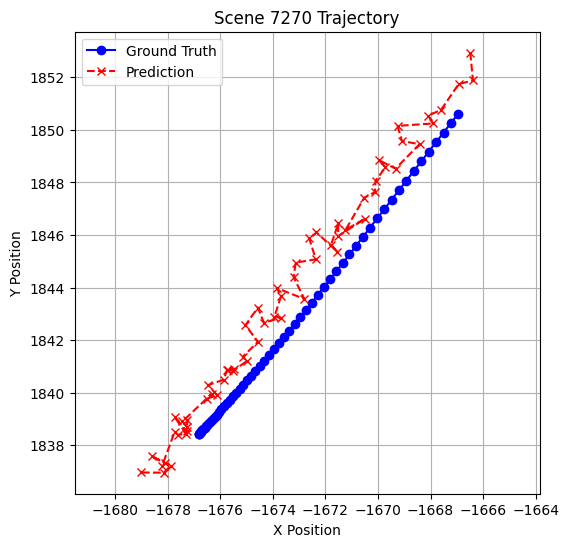

In [9]:
from utils import visualize_trajectory

# run this cell to visualize how the model's predicted trajectory compares to the real one on some data points
visualize_trajectory(train_dataset, deep_cnn_model, np.random.randint(0, len(train_dataset)))